### Load libraries

In [6]:
!pip install keras

  Using cached Keras-2.4.3-py2.py3-none-any.whl (36 kB)


In [7]:
import pandas as pd
import numpy as np
import os
import cv2
import random

import matplotlib.pyplot as plt
%matplotlib inline

import keras
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dense, Dropout, Activation, Flatten

### Load data

In [2]:
# Setting base directory path
base_dir = 'D://MS//Semesters//Fall 20//DSP//Project//Traffic-Sign-Classification-main (1)//Traffic-Sign-Classification-main//data//binary//'

# Setting directory path for stop and non-stop images
stop_dir = base_dir + '/stop/'
nonstop_dir = base_dir + '/non-stop/'

print('Total stop sign images:', len(os.listdir(stop_dir)))
print('Total non stop sign images:', len(os.listdir(nonstop_dir)))

Total stop sign images: 241
Total non stop sign images: 227


In [3]:
# Get path of each image in the stop and non-stop folder
stop_images = [stop_dir + '/{}'.format(i) for i in os.listdir(stop_dir)]
nonstop_images = [nonstop_dir + '/{}'.format(i) for i in os.listdir(nonstop_dir)]

In [4]:
# Desired dimension for each image in the dataset
width = 150
height = 150

# 3 for color images and 1 for grayscale
channels = 3

# Function to get x input(array representing picture) and the corresponding label
def read_process_images(image_list, label):
    X = []
    Y = []
    
    for image in image_list:
        print('abspath:     ', os.path.abspath(image))
        print('abs dirname: ', os.path.dirname(os.path.abspath(image)))
        image_arr = cv2.imread(image, cv2.IMREAD_UNCHANGED)
        image_arr = cv2.cvtColor(image_arr, cv2.COLOR_BGR2RGB )
        X.append(cv2.resize(image_arr ,  (width, height), interpolation=cv2.INTER_AREA))
        Y.append(label)
    return X, Y

       

In [5]:
# Since the model can only work with numeric data, we will use 0 for non-stop and 1 for stop sign images
# preprocess stop sign images 
stop_x, stop_y = read_process_images(stop_images, 1)

# preprocess non-stop sign images
nonstop_x, nonstop_y = read_process_images(nonstop_images, 0)

# Combine stop and non-stop images into X and Y labels
X = stop_x + nonstop_x
Y = stop_y + nonstop_y
print('Length of X: ', len(X))
print('Length of Y: ', len(Y))

abspath:      D:\MS\Semesters\Fall 20\DSP\Project\Traffic-Sign-Classification-main (1)\Traffic-Sign-Classification-main\data\binary\stop\stop1.jpg
abs dirname:  D:\MS\Semesters\Fall 20\DSP\Project\Traffic-Sign-Classification-main (1)\Traffic-Sign-Classification-main\data\binary\stop
abspath:      D:\MS\Semesters\Fall 20\DSP\Project\Traffic-Sign-Classification-main (1)\Traffic-Sign-Classification-main\data\binary\stop\stop10.jpg
abs dirname:  D:\MS\Semesters\Fall 20\DSP\Project\Traffic-Sign-Classification-main (1)\Traffic-Sign-Classification-main\data\binary\stop
abspath:      D:\MS\Semesters\Fall 20\DSP\Project\Traffic-Sign-Classification-main (1)\Traffic-Sign-Classification-main\data\binary\stop\stop100.jpg
abs dirname:  D:\MS\Semesters\Fall 20\DSP\Project\Traffic-Sign-Classification-main (1)\Traffic-Sign-Classification-main\data\binary\stop
abspath:      D:\MS\Semesters\Fall 20\DSP\Project\Traffic-Sign-Classification-main (1)\Traffic-Sign-Classification-main\data\binary\stop\stop101.

In [6]:
# Convert list to array
X = np.array(X)
Y = np.array(Y)

In [7]:
# Dimensions of input - 468 rows with 150*150 pixels and 3 for rgb
X.shape

(468, 150, 150, 3)

In [8]:
# Dimension of label - 486 rows
Y.shape

(468,)

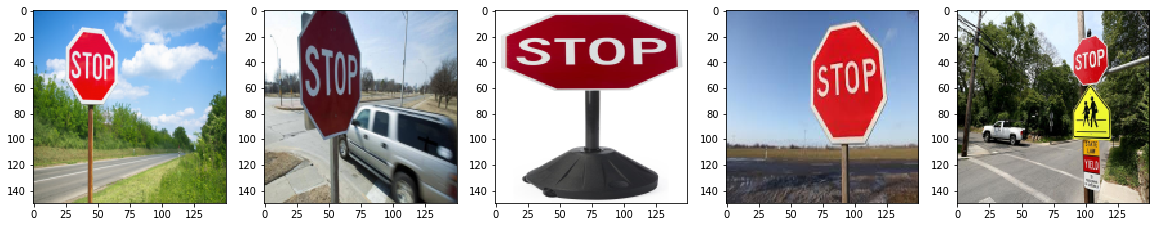

In [9]:
# Displaying few samples from dataset
plt.figure(figsize=(20,10))
columns = 5
for i in range(columns):
    plt.subplot(5/columns + 1, columns, i+1)
    plt.imshow(X[i])

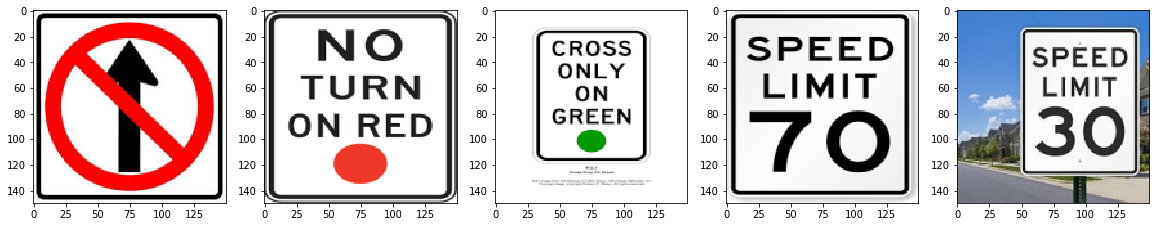

In [10]:
# Displaying few samples from dataset
plt.figure(figsize=(20,10))
columns = 5
nonstopindex = 300
for i in range(columns):
    plt.subplot(5/columns + 1, columns, i+1)
    plt.imshow(X[nonstopindex])
    nonstopindex = nonstopindex + 1

In [11]:

from keras.utils import to_categorical
# Shuffle both inputs and labels for splitting in the future.
shuffler = np.random.permutation(len(X))
X = X[shuffler]
Y = Y[shuffler]

#Y = to_categorical(Y)

### Create train-validation split on data

In [12]:
# Create train test split with 20% of data in testing data
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=1)

print('Shape of train images: ', x_train.shape)
print('Shape of train labels: ', y_train.shape)

print()

print('Shape of validation images: ', x_test.shape)
print('Shape of validation labels: ', y_test.shape)

Shape of train images:  (374, 150, 150, 3)
Shape of train labels:  (374,)

Shape of validation images:  (94, 150, 150, 3)
Shape of validation labels:  (94,)


In [14]:
# Length of train and validation data
ntrain = len(x_train)
ntest = len(x_test)

We have 374 training images and 94 validation images. Since the dataset is small, we will use image augmentation before training the model.

### Data Preprocessing with image augmentation

In [15]:
# Pre-processing image with the help of image augmentation

train_datagen = ImageDataGenerator(rescale= 1./255, # Normalization.
                                   rotation_range = 40,
                                   width_shift_range = 0.2,
                                   height_shift_range = 0.2,
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   horizontal_flip = True,)

# Validation dataset doesn't need image augmentation. Only normalization
test_datagen = ImageDataGenerator(rescale=1./255)

We performed the following operations:

- Normalization: We pass the rescale option to the ImageDataGenerator object. The rescale=1./255 normalizes the image pixel values to have zero mean and standard deviation of 1. It helps the model to generally learn and update its parameters efficiently.
- Image augmentation. They tell the ImageDataGenerator to randomly apply some transformation to the Image. This will help to augment our data-set and improve generalization. For example it will apply transformations like rotation, height shifting, width shiftig and zooming in out.

In [16]:
# Defining batch size. It has to be the power of 2
# The batch size tells the data generator to only take the specified batch(16 in our case) of images at a time.
batch_size = 16

# Create image generators using the train and test data
train_generator = train_datagen.flow(x_train, y_train, batch_size=batch_size)
test_generator = test_datagen.flow(x_test, y_test, batch_size=batch_size)

### Model building - CNN classifier

In [17]:
model = Sequential()

# First convolution as the input layer with relu activation. 
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(150,150,3)))
model.add(MaxPooling2D((2, 2)))

# Second convolution with relu activation and 64 output filters
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))

# Third convolution with relu activation and 128 output filters
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))

# Flatten the output layer to 1 dimension
model.add(Flatten())

# Add a dropout rate of 0.5 Dropout randomly drops some layers in a neural networks and then learns with the reduced network.
model.add(Dropout(0.5))

# Add a fully connected layer with 100 hidden units and ReLU activation
model.add(Dense(100, activation='relu'))

# Add a final sigmoid layer for classification
model.add(Dense(1, activation='sigmoid'))

model.summary()


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 148, 148, 32)      896       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 72, 72, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 36, 36, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 34, 34, 128)       73856     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 17, 17, 128)       0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 36992)           

In [18]:
from tensorflow.keras.optimizers import RMSprop

# Compiling the model
# initiate adam optimizer with learning rate 0.0001
opt = keras.optimizers.Adam(lr=0.0001)

# Compiling the model
model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [19]:
# Training model
history = model.fit_generator(train_generator,
                             steps_per_epoch= ntrain// batch_size,
                             epochs=10,
                             validation_data=test_generator,
                             validation_steps= ntest// batch_size)


Epoch 1/10
23/23 [==============================] - 8s 363ms/step - loss: 0.5383 - accuracy: 0.7542 - val_loss: 0.4162 - val_accuracy: 0.8500
Epoch 2/10
23/23 [==============================] - 8s 335ms/step - loss: 0.2940 - accuracy: 0.8827 - val_loss: 0.1010 - val_accuracy: 0.8077
Epoch 3/10
23/23 [==============================] - 8s 337ms/step - loss: 0.2340 - accuracy: 0.9134 - val_loss: 0.0848 - val_accuracy: 0.8846
Epoch 4/10
23/23 [==============================] - 8s 337ms/step - loss: 0.1912 - accuracy: 0.9274 - val_loss: 0.1459 - val_accuracy: 0.8590
Epoch 5/10
23/23 [==============================] - 8s 342ms/step - loss: 0.1472 - accuracy: 0.9497 - val_loss: 0.3172 - val_accuracy: 0.8718
Epoch 6/10
23/23 [==============================] - 8s 339ms/step - loss: 0.1409 - accuracy: 0.9497 - val_loss: 0.0327 - val_accuracy: 0.9103
Epoch 7/10
23/23 [==============================] - 8s 363ms/step - loss: 0.1196 - accuracy: 0.9620 - val_loss: 0.2800 - val_accuracy: 0.9000
Epoch

In [20]:
# Evaluate model based on accuracy and f1_score
from sklearn.metrics import accuracy_score, f1_score

y_test_predict = model.predict_classes(x_test, verbose=0)
accuracy = accuracy_score(y_test, y_test_predict)
print('Accuracy: %f' % accuracy)

f1 = f1_score(y_test, y_test_predict)
print('F1_score: %f' % f1)

Accuracy: 0.861702
F1_score: 0.839506


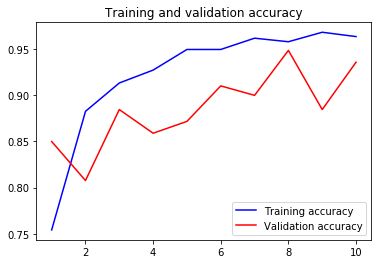

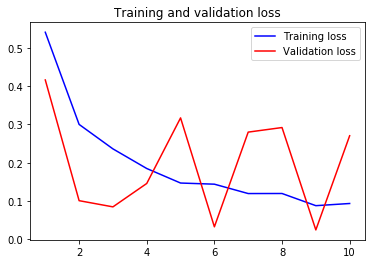

In [21]:
# Plot training and validation accuracy and loss for the model epochs
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

# Train and validation accuracy
plt.plot(epochs, acc, 'b', label='Training accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

# Train and validation loss
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

[0]
 This is a non-stop sign


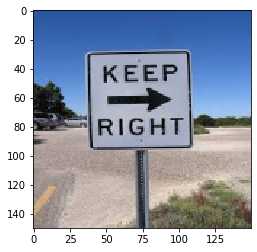

In [42]:
# Example prediction

classes = model.predict_classes(x_test, batch_size=10)
print(classes[93])
plt.imshow(x_test[93])
if classes[93]<0.5:
        print(" This is a non-stop sign")
else:
        print(" This is a stop sign")